In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [3]:
train_data, valid_data, test_data = lbln.load_data_shared(
                     '../../TrainingData/LabeledData-2015-09-06/',
                     'capture',
                     '../../TrainingData/LabeledData-2015-09-06/labels.dat',
                      n_train=15000,
                      n_validation=2000,
                      n_test=1500,
                      label_mask=1)

In [82]:
mini_batch_size = 10

In [85]:
network = lbln.Network([
#         ConvPoolLayer(image_shape=(mini_batch_size, 3, 64, 64), 
#                       filter_shape=(20, 3, 5, 5), 
#                       poolsize=(2, 2)),
        FullyConnectedLayer(n_in=64*64*3, n_out=5)
#         FullyConnectedLayer(n_in=150, n_out=5)
    ], mini_batch_size)

In [89]:
network.SGD(train_data, 200, mini_batch_size, 0.01, valid_data, test_data)

--- Training mini-batch number 0 ---
--- Training mini-batch number 1000 ---
  Epoch 0: validation accuracy -0.033156
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.033324
    Current cost on training set: 0.0393675986178
--- Training mini-batch number 2000 ---
  Epoch 1: validation accuracy -0.027466
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.027533
    Current cost on training set: 0.0310213168908
--- Training mini-batch number 3000 ---
--- Training mini-batch number 4000 ---
  Epoch 2: validation accuracy -0.023735
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.023743
    Current cost on training set: 0.0261907676846
--- Training mini-batch number 5000 ---
  Epoch 3: validation accuracy -0.021021
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.020994
    Current cost on training set: 0.022912143

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [79]:
def determine_test_accuracy(net, xs, ts, offset, allowed_dev):
    assert len(xs) == len(ts)
    errors = 0
    for x, t in zip(xs, ts):
        prediction = net.get_single_output(x)
#         print 't:', t
#         print 'p:', prediction
#         print abs(t - prediction) / (t + offset)
        
#         print (t-offset)/allowed_dev
#         print (t+offset)*allowed_dev
#         print np.greater(prediction - (t-offset)/allowed_dev, 0)
#         print np.greater((t+offset)*allowed_dev - prediction, 0)
        err = 1 - np.prod(np.greater(prediction - (t-offset)/allowed_dev, 0)) * np.prod(np.greater((t+offset)*allowed_dev - prediction, 0))
#         if err == 1:
#             print t
#             print prediction
#             print np.greater(prediction - (t-offset)/allowed_dev, 0)
#             print np.greater((t+offset)*allowed_dev - prediction, 0)
#             print
        errors += err
        
#         if np.max(abs(t - prediction) / (t + offset)) > allowed_dev:
#             print '(error)'
#             errors += 1
    return (1.0 * len(xs)-errors) / len(xs)

In [62]:
# minibatch = 1
# index = 8

# im = test_data[0].get_value()[minibatch*mini_batch_size + index].reshape(64, 64, 3)
# plt.imshow(im, interpolation='nearest')

# network_function = theano.function([network.x], network.output)

# prediction = network_function(test_data[0].get_value()[minibatch*mini_batch_size: (minibatch+1)*mini_batch_size])[index]
# actual = test_data[1].get_value()[minibatch*mini_batch_size + index]

# print prediction
# print
# print actual


# # print determine_test_accuracy(network, test_data[0].get_value(), test_data[1].get_value(), 0.2, 1.2)

# print 
# print 'Mean predicted output', np.mean(prediction)
# print 'Mean actual output', np.mean(actual)
# print 'Squared error:', np.mean((actual - prediction) ** 2)
# # print 'Loss', np.mean(-np.log(1.0000001 - np.abs(prediction - actual)))

In [90]:
print determine_test_accuracy(network, test_data[0].get_value(), test_data[1].get_value(), 0.2, 1.2)

0.971333333333


In [91]:
test_data_xs = test_data[0].get_value()
test_data_ts = test_data[1].get_value()

Worst prediction:
Target:     [ 0.         0.9600002  0.6        0.         0.       ]
Prediction: [ 0.01496562  0.07458536  0.07978594  0.01167097  0.02399554]


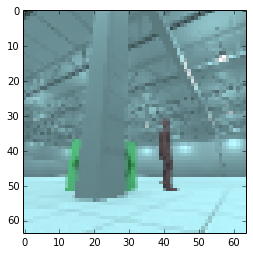

In [105]:
# Determine all errors on the test images
classifications = []
for x, t in zip(test_data_xs, test_data_ts):
    prediction = network.get_single_output(x)
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))

classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)

print 'Worst prediction:'
print 'Target:    ', classifications[0][1]
print 'Prediction:', classifications[0][2]
plt.imshow(classifications[0][0].reshape(64, 64, 3), interpolation='nearest')
plt.show()


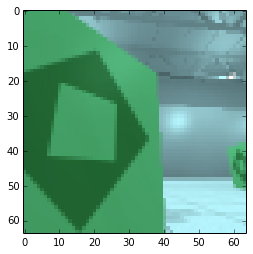

t: [ 1.   1.   1.   0.2  0.2]
p: [ 0.98368013  0.9963562   0.94028349  0.13443341  0.09000914]
d: 0.00404852890994


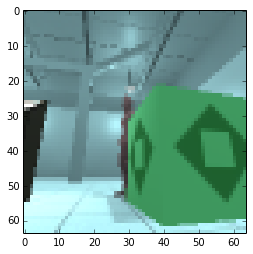

t: [ 0.   0.   0.6  1.   1. ]
p: [ 0.0356137   0.06029087  0.61520256  0.96372753  0.98043965]
d: 0.00136654833914


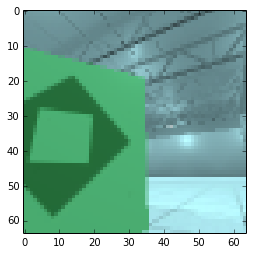

t: [ 1.         1.         0.8800001  0.         0.       ]
p: [ 0.9928092   0.98880063  0.86525446  0.05487725  0.03075438]
d: 0.000870382404325


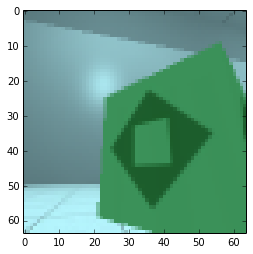

t: [ 0.   0.2  1.   1.   1. ]
p: [ 0.04921404  0.27971793  0.91741696  0.97006296  0.98231376]
d: 0.00336119160634


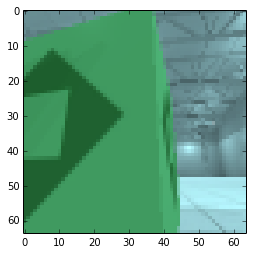

t: [ 1.         1.         1.         0.5599999  0.       ]
p: [ 0.9903318   0.98435836  0.98938119  0.62322754  0.02025196]
d: 0.000971754117477


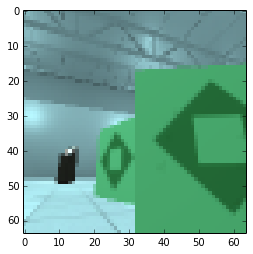

t: [ 0.    0.32  1.    1.    1.  ]
p: [ 0.03706695  0.35994851  0.96225134  0.93789307  0.9902425 ]
d: 0.0016694566606


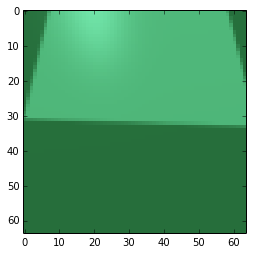

t: [ 1.  1.  1.  1.  1.]
p: [ 0.9843486   0.98560252  0.97454775  0.97145966  0.98395181]
d: 0.000434433201464


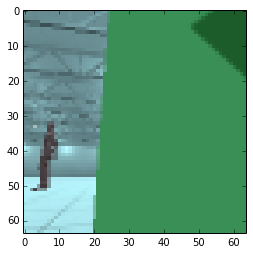

t: [ 0.    0.28  1.    1.    1.  ]
p: [ 0.01688159  0.22435892  0.98570679  0.98915518  0.99477707]
d: 0.000746020699527


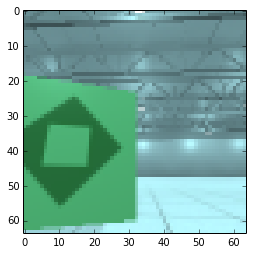

t: [ 1.   1.   0.6  0.   0. ]
p: [ 0.98556869  0.98744073  0.69799566  0.02603814  0.02611711]
d: 0.00226584719952


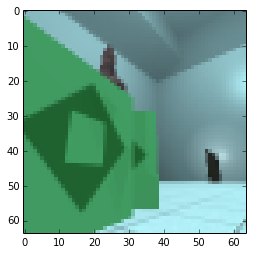

t: [ 1.         1.         0.3999999  0.12       0.       ]
p: [ 0.95749759  0.99447782  0.91874752  0.09393857  0.0426633 ]
d: 0.0546870794547


In [64]:
high_signal_images = np.asarray([(x, t) for (x, t) in zip(test_data_xs, test_data_ts) if np.mean(t) > 0.5])

for x, t in high_signal_images[:10]:
    prediction = network.get_single_output(x)
    plt.imshow(x.reshape(64, 64, 3), interpolation='nearest')
    plt.show()
    print 't:', t
    print 'p:', prediction
    print 'd:', np.mean((t - prediction) ** 2)


In [ ]:
testfun = theano.function([network.x_single], network.layers[0].single_output)

In [ ]:
testfun(test_data[0].get_value()[9]).shape

In [18]:
## AVERAGE SQUARED MAGNITUDE OF SENSOR VALUES:
# for t in test_data[1].get_value()[:10]:
#     print t, t ** 2, np.mean(t ** 2)

test_targets = train_data[1].get_value()

print np.mean(test_targets)

print np.mean(test_targets ** 2)

print np.mean((test_targets - np.mean(test_targets)) ** 2)

0.148949867168
0.126363714977
0.104177652048
